### Battery Classification: PCA & Clustering For Chemistry Classification

In [9]:
#Import packages
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import Image, display

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
print('Packages Loaded....')

Packages Loaded....


In this notebook, we'll examine if Principal Component Analysis (PCA) could be used in conjustion with k-means clustering to distinguish the chemistry specific cells based on differences in their input features. PCA works by reducing the dimensionality by identifying a new set of components in a lower dimension plane that maximizes the variance captured. By applying PCA we may be able to visually segregate chemistry classes into discrete, separated clusters. Let's get started....

We'll start by taking the characteristic features (voltage, C-rate, and temperature), and extract their aggregated characteristics (mean, standard deviation, max, and min). Each chemistry has a unique voltage curvature, which changes slightly as a functon of C-rate and temperature, as shown in *01_Background.ipynb*

#### Let's start by constructing the aggregated feature-set: 

In [10]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features, clip=True):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), desired_features (list), clip (bool)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features].copy()
    
    # Apply voltage clipping if enabled
    if clip and 'voltage_v' in tdf.columns:
        tdf = tdf[(tdf['voltage_v'] >= 3.0) & (tdf['voltage_v'] <= 3.6)]
    
    # If no data remains after clipping, return None
    if len(tdf) == 0:
        return None

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir, clip=True): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str), clip (bool) - if True, filters voltage between 3.0 and 3.6V
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features, clip=clip)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features, clip=clip)
                    
                    # Skip if either charge or discharge had no data after clipping
                    if charge_data is None or discharge_data is None:
                        continue

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


def scrub_values(input_df): 
    """This function takes the input dataframe and removes any features from the dataframe if they are found 
     in the pre-specified strip_cols list, ultimately returning the subset feature dataframe.  
    Inputs: input_df (pandas dataframe)
    Outputs: strip_df (pandas dataframe)"""

    #Now let's remove unneeded features: 
    strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
                'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
                'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
                'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
                'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
                'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
                'discharge_cycle_index_min', 'discharge_cycle_index_std',
                'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
                'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

    strip_df = input_df.drop(columns=strip_cols, errors='ignore')
    strip_df = strip_df.iloc[:, :-1]
    strip_df.describe()
    return strip_df


input_dir = r'..\assets\processed'
print('Generating initial training data')
result_df = agg_chem_features(input_dir, clip=True)  # Set clip=True to filter voltage between 3.0-3.6V
print('Removing unwanted features')
strip_df = scrub_values(result_df).dropna()

print('Here is a quick overview:')
strip_df.sample(3)


Generating initial training data
Removing unwanted features
Here is a quick overview:
Removing unwanted features
Here is a quick overview:


,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,chemistry,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
67,3.514667,0.116351,3.173900,3.599847,0.725,303.0,NMC,3.452408,0.128233,3.000000,3.599927,0.500
251,3.497860,0.106135,3.007887,3.600000,1.000,298.0,LFP,3.133582,0.083227,3.000063,3.585300,1.000
125,3.534200,0.021496,3.519000,3.549400,2.125,303.0,NMC,3.571051,0.016759,3.544700,3.599700,1.975


A brief note on the aggregated features. While we don't need the min, max, and standard deviation for most of the features, the charge and discharge features are intentionally separated because of hysteresis phenomena observed in battery cycling where the voltage curve is dependent on the orientation as shown in *01_Background.ipynb*

Let's remove unnecessary features: 

#### Now that we've aggegated our data features, let's apply PCA to see if we can classify the chemistry sets by clustering...

Number of PCA components needed for 95% variance: 8


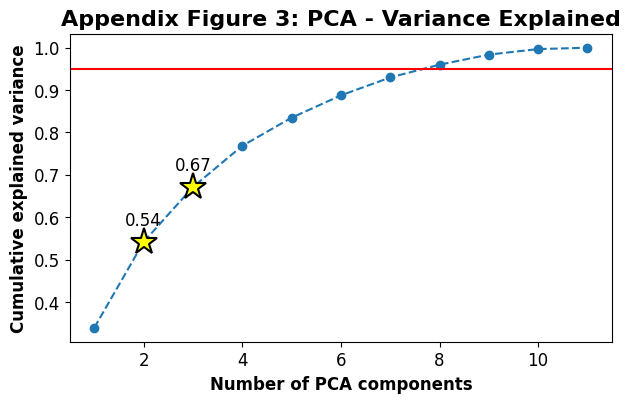

In [11]:
#Now train PCA model:
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find number of components needed for 95% variance
n_components_95 = (cumulative_variance < 0.95).sum() + 1
print(f"Number of PCA components needed for 95% variance: {n_components_95}")

# Plot cumulative variance
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')

# Add yellow stars at 2 and 3 components
plt.plot(2, cumulative_variance[1], marker='*', color='yellow', markersize=20, markeredgecolor='black', markeredgewidth=1.5)
plt.plot(3, cumulative_variance[2], marker='*', color='yellow', markersize=20, markeredgecolor='black', markeredgewidth=1.5)

# Add text labels with values
plt.text(2, cumulative_variance[1] + 0.03, f'{cumulative_variance[1]:.2f}', fontsize=12, va='bottom', ha='center')
plt.text(3, cumulative_variance[2] + 0.03, f'{cumulative_variance[2]:.2f}', fontsize=12, va='bottom', ha='center')

plt.xlabel("Number of PCA components", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative explained variance", fontsize=12, fontweight='bold')
plt.title("Appendix Figure 3: PCA - Variance Explained", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


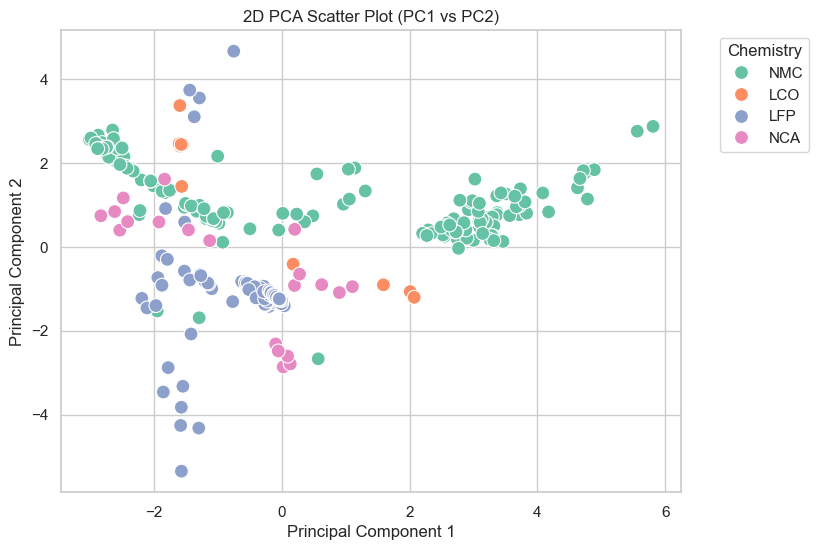

In [12]:
#Let's see how well a 2D projection would separate the groups: 
sns.set(style="whitegrid")

# Prepare numeric features (exclude chemistry) ---
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca_2[:,0],
    'PC2': X_pca_2[:,1],
    'chemistry': strip_df['chemistry'],
    'cluster': clusters
})

# Now Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='chemistry',
    palette='Set2',
    s=100
)
plt.title("2D PCA Scatter Plot (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Chemistry', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


At a glance we can see a clear differentiation between the LFP chemistry and non-LFP chemistries when reducing the dataset to just 2 principal components. However, we cannot clearly distinguish NMC, NCA, and LCO chemistries between eachother. Let's now example if adding a 3D principal component would enable proper chemistry classification....  

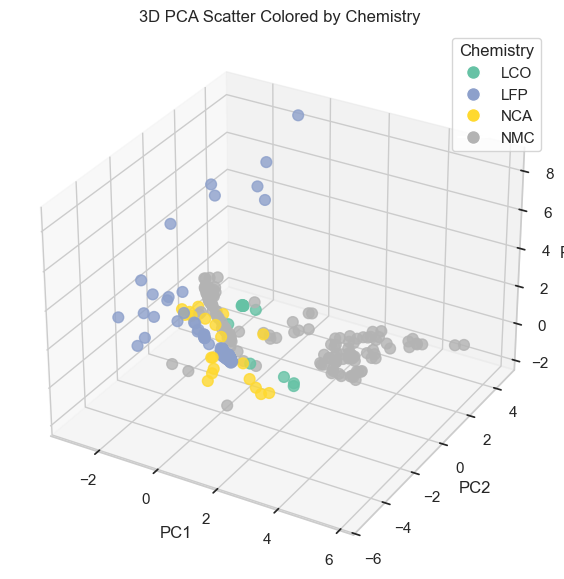

In [13]:
# Prepare numeric features (exclude chemistry)
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 3 components
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

# KMeans clustering (optional, 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Prepare chemistry codes and labels
chem_codes = strip_df['chemistry'].astype('category').cat.codes
chem_labels = strip_df['chemistry'].astype('category').cat.categories

# 3D scatter plot colored by chemistry
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3[:,0], 
    X_pca_3[:,1], 
    X_pca_3[:,2], 
    c=chem_codes, 
    cmap='Set2', 
    s=60, 
    alpha=0.8
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Colored by Chemistry')

# Correct legend that matches scatter colors
scatter_colors = scatter.cmap(scatter.norm(range(len(chem_labels))))
handles = [Line2D([0],[0], marker='o', color='w', 
                  markerfacecolor=scatter_colors[i], 
                  markersize=10)
           for i in range(len(chem_labels))]
ax.legend(handles, chem_labels, title='Chemistry')

plt.show()



Unfortunately, using just 3 principal components is unlikely to be suffiicent to distinguish between LCO, NCA, and NMC chemistries when applying a secondary clustering algorithm. We'll show a brief example of how the performance would be using a Kmeans aglorithm

Accuracy: 0.636094674556213

Classification report:
              precision    recall  f1-score   support

         LCO       0.00      0.00      0.00        14
         LFP       0.61      0.96      0.75       159
         NCA       0.00      0.00      0.00        20
         NMC       0.71      0.43      0.54       145

    accuracy                           0.64       338
   macro avg       0.33      0.35      0.32       338
weighted avg       0.59      0.64      0.58       338


Confusion matrix:
     NMC  LCO  LFP  NCA
NMC    0    4    0   10
LCO    0  152    0    7
LFP    0   11    0    9
NCA    0   82    0   63


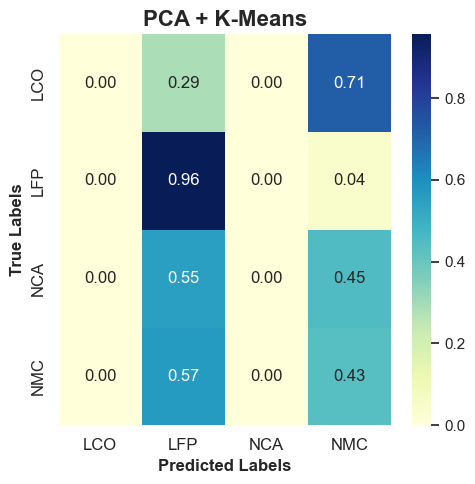

In [15]:
results = pd.DataFrame({
    'chemistry': strip_df['chemistry'],
    'cluster': clusters
})

# Cross-tab (like confusion matrix)
ct = pd.crosstab(results['chemistry'], results['cluster'])
ct

# Map each cluster to the most frequent chemistry inside it
cluster_map = {}
for c in np.unique(clusters):
    mask = clusters == c
    majority_label = results.loc[mask, 'chemistry'].mode()[0]
    cluster_map[c] = majority_label

# Apply the mapping
pred_labels = [cluster_map[c] for c in clusters]

print("Accuracy:", accuracy_score(results['chemistry'], pred_labels))
print("\nClassification report:")
print(classification_report(results['chemistry'], pred_labels, zero_division=0))

print("\nConfusion matrix:")
print(pd.DataFrame(confusion_matrix(results['chemistry'], pred_labels),
                   index=results['chemistry'].unique(),
                   columns=results['chemistry'].unique()))

# Compute confusion matrix
cm = confusion_matrix(results['chemistry'], pred_labels, normalize='true')

# Get label order (same as rows/columns)
labels = sorted(results['chemistry'].unique())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})


plt.title("PCA + K-Means", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

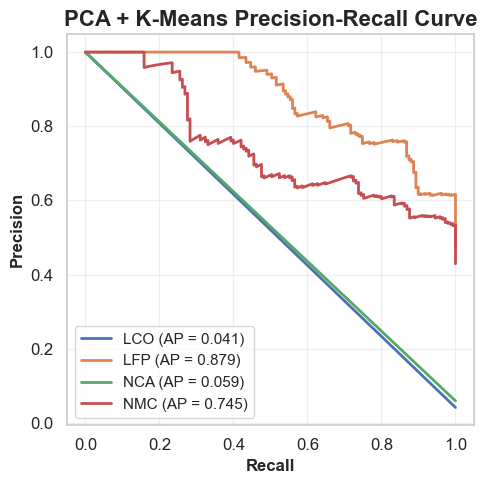


Average Precision Scores by Chemistry:
  LCO: 0.041
  LFP: 0.879
  NCA: 0.059
  NMC: 0.745


In [19]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Get predicted probabilities from kmeans - use distances to cluster centers
from scipy.spatial.distance import cdist

# Calculate distances to all cluster centers
distances = cdist(X_scaled, kmeans.cluster_centers_, metric='euclidean')

# Convert distances to probabilities (inverse distance, normalized)
# Smaller distance = higher probability
inv_distances = 1 / (distances + 1e-10)  # Add small constant to avoid division by zero
probabilities = inv_distances / inv_distances.sum(axis=1, keepdims=True)

# Map cluster probabilities to chemistry labels
# Create a probability matrix for each chemistry class
n_samples = len(results['chemistry'])
n_classes = len(labels)
y_proba = np.zeros((n_samples, n_classes))

for cluster_idx, chem in cluster_map.items():
    class_idx = labels.index(chem)
    y_proba[:, class_idx] += probabilities[:, cluster_idx]

# Binarize true labels for multi-class PR curve
y_encoded = results['chemistry'].astype('category').cat.codes
y_bin = label_binarize(y_encoded, classes=range(len(labels)))

# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(5, 5))

for i, class_name in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
    avg_precision = average_precision_score(y_bin[:, i], y_proba[:, i])
    ax.plot(recall, precision, linewidth=2, 
            label=f'{class_name} (AP = {avg_precision:.3f})')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('PCA + K-Means Precision-Recall Curve', 
            fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

print("\nAverage Precision Scores by Chemistry:")
for i, class_name in enumerate(labels):
    ap_score = average_precision_score(y_bin[:, i], y_proba[:, i])
    print(f"  {class_name}: {ap_score:.3f}")


So we can clearly see the model performance is not good for LCO or NCA chemistries. This could be due to the limited numberof records available for this chemistry, when compared to the significant quantity avaiable for LFP and NMC. While the initial strong model performance could be concerning, it's also indicative of separating between 2 distinct profiles, that of LFP and that of anything else. When we compare to figure 5 in *01_Background,ipynb* the non-LFP profiles are quite similar, so our model appears biased to the appearance-dominant class instead (NMC).

Next, let's also see how much storage is required for this model method. We'd need to store both the K-means model, the PCA transformer, and the 
 

In [8]:
import pickle 

file_path = 'kmeans_model.pkl'
with open(file_path, 'wb') as f:
    pickle.dump({
        'scaler': scaler,
        'pca': pca_3,
        'kmeans': kmeans
    }, f)

# Check Model Size
size_bytes = os.path.getsize(file_path)
size_kb = size_bytes / 1024
size_mb = size_kb / 1024
print(f"Model size: {size_bytes} bytes ({size_kb:.2f} KB / {size_mb:.2f} MB)")

# Delete File Since Not Needed
os.remove(file_path)
print(f"File '{file_path}' has been deleted.")

Model size: 4110 bytes (4.01 KB / 0.00 MB)
File 'kmeans_model.pkl' has been deleted.


So we can see the model would require ~4kb, which is computationally cheap and manageable within our intended application. However, the model biases to predicting all non-LFP chemistries as NMC. So this method would not be a robust solution option. We could try hyperparameter tuning this model, but the main parameter (cluster quantity) should be fixed to the 4 classes we intend to classify. Instead, let's proceed by exploring other options...